In [14]:
import numpy as np
# from dolfin import *
import matplotlib.pyplot as plt
from tqdm import tqdm

# Load the matrix and vector from the files
Ak_np = np.load("Ak.npy")
L_np = np.load("L.npy")

# Initial guess (zero vector)
x0 = np.zeros(len(L_np))

# Set tolerance and maximum iterations
tol = 1e-8
max_iter = 800

In [15]:
# Define the grid for the unit square
n = 100
x_range = np.arange(0, 1 + 1 / n, 1 / n)
y_range = np.arange(0, 1 + 1 / n, 1 / n)
xy = np.array(np.meshgrid(x_range, y_range)).T.reshape(-1, 2)

# Simulate coord_map for mapping solution to mesh (based on finite element DoFs)
# coord_map should be replaced with the actual DoF coordinates from your FEM solver
coord_map = xy.copy()

In [19]:
# Jacobi preconditioning
M = np.diag(Ak_np)  # Diagonal elements of A
M_inv = np.diag(1 / M)  # Inverse of diagonal elements
b_precond = M_inv @ L_np  # Preconditioned RHS

In [16]:
# Conjugate Residual Method with Residual Tracking
def conjugate_residual(A, x0, b, max_iter, tol):
    x = x0.copy()
    r = b - A @ x0
    p = r.copy()
    Ap = A @ p
    residuals = [np.linalg.norm(r)]  # Track initial residual norm

    for k in tqdm(range(max_iter)):
        Ar = A @ r
        alpha = (np.transpose(r) @ Ar) / (np.transpose(Ap) @ Ap)
        x_new = x + alpha * p

        # Check for convergence
        if np.linalg.norm(x_new - x) / np.linalg.norm(x_new) < tol:
            residuals.append(np.linalg.norm(b - A @ x_new))
            return x_new, residuals

        r_new = r - alpha * Ap
        residuals.append(np.linalg.norm(r_new))  # Track residual norm
        Ar_new = A @ r_new
        beta = (np.transpose(r_new) @ Ar_new) / (np.transpose(r) @ Ar)
        p_new = r_new + beta * p
        Ap_new = Ar_new + beta * Ap

        x, r, p, Ap = x_new, r_new, p_new, Ap_new

    return x, residuals

    
# Solve using the Conjugate Gradient method with convergence tracking
def conjugate_gradient(A, b, x, tol, max_iter):
    r = b - A @ x
    residuals = [np.linalg.norm(r)]
    if residuals[-1] < tol:
        return x, residuals
    p = r.copy()
    r_old = np.transpose(r) @ r

    for k in tqdm(range(max_iter)):
        alpha = r_old / (np.transpose(p) @ (A @ p))
        x = x + alpha * p
        r = r - alpha * (A @ p)
        residuals.append(np.linalg.norm(r))

        if residuals[-1] < tol:
            break

        r_new = np.transpose(r) @ r
        beta = r_new / r_old
        p = r + beta * p
        r_old = r_new

    return x, residuals

In [22]:
from tqdm import tqdm

def conjugate_residual_precond(A, x0, b, max_iter, tol):
    # Jacobi preconditioner: M = diag(A), M_inv = diag(1 / diag(A))
    M_inv = np.diag(1 / np.diag(A))
    b_precond = M_inv @ b  # Preconditioned RHS

    x = x0.copy()
    r = b_precond - M_inv @ (A @ x0)
    p = r.copy()
    Ap = M_inv @ (A @ p)
    residuals = [np.linalg.norm(r)]  # Track initial residual norm

    for k in tqdm(range(max_iter)):
        Ar = M_inv @ (A @ r)
        alpha = (np.transpose(r) @ Ar) / (np.transpose(Ap) @ Ap)
        x_new = x + alpha * p

        # Check for convergence
        if np.linalg.norm(x_new - x) / np.linalg.norm(x_new) < tol:
            residuals.append(np.linalg.norm(b - A @ x_new))
            return x_new, residuals

        r_new = r - alpha * Ap
        residuals.append(np.linalg.norm(r_new))  # Track residual norm
        Ar_new = M_inv @ (A @ r_new)
        beta = (np.transpose(r_new) @ Ar_new) / (np.transpose(r) @ Ar)
        p_new = r_new + beta * p
        Ap_new = Ar_new + beta * Ap

        x, r, p, Ap = x_new, r_new, p_new, Ap_new

    return x, residuals


def conjugate_gradient_precond(A, b, x, tol, max_iter):
    # Jacobi preconditioner: M = diag(A), M_inv = diag(1 / diag(A))
    M_inv = np.diag(1 / np.diag(A))
    b_precond = M_inv @ b  # Preconditioned RHS

    r = b_precond - M_inv @ (A @ x)
    residuals = [np.linalg.norm(r)]
    if residuals[-1] < tol:
        return x, residuals
    p = r.copy()
    r_old = np.transpose(r) @ r

    for k in tqdm(range(max_iter)):
        Ap = M_inv @ (A @ p)
        alpha = r_old / (np.transpose(p) @ Ap)
        x = x + alpha * p
        r = r - alpha * Ap
        residuals.append(np.linalg.norm(r))

        if residuals[-1] < tol:
            break

        r_new = np.transpose(r) @ r
        beta = r_new / r_old
        p = r + beta * p
        r_old = r_new

    return x, residuals



In [24]:
solution_cg,residuals = conjugate_gradient_precond(Ak_np, L_np, x0, tol, max_iter)

# Create a mapping from coord_map to indices in xy
coord_map_indices = {tuple(coord): i for i, coord in enumerate(coord_map)}

# Use the mapping to assign values from solution_cg to the correct positions in u_reshaped
u_reshaped_grad_precond = np.zeros((n + 1, n + 1))

for j, coord in enumerate(xy):
    index = coord_map_indices.get(tuple(coord))
    if index is not None:
        u_reshaped_grad_precond[j // (n + 1), j % (n + 1)] = solution_cg[index]


# Map the solution to the mesh grid
# u_reshaped = np.zeros((n + 1) * (n + 1))

# for i, coord in tqdm(enumerate(coord_map)):
#     for j, xy_val in enumerate(xy):
#         if np.allclose(coord, xy_val):
#             u_reshaped[j] = solution_cg[i]

u_reshaped_grad_precond = u_reshaped_grad_precond.reshape(n + 1, n + 1)


100%|██████████| 800/800 [06:02<00:00,  2.21it/s]


In [34]:
solution_cg,residuals_cg = conjugate_gradient(Ak_np, L_np, x0, tol, max_iter)

# Create a mapping from coord_map to indices in xy
coord_map_indices = {tuple(coord): i for i, coord in enumerate(coord_map)}

# Use the mapping to assign values from solution_cg to the correct positions in u_reshaped
u_reshaped_cg = np.zeros((n + 1, n + 1))

for j, coord in enumerate(xy):
    index = coord_map_indices.get(tuple(coord))
    if index is not None:
        u_reshaped_cg[j // (n + 1), j % (n + 1)] = solution_cg[index]


# Map the solution to the mesh grid
# u_reshaped = np.zeros((n + 1) * (n + 1))

# for i, coord in tqdm(enumerate(coord_map)):
#     for j, xy_val in enumerate(xy):
#         if np.allclose(coord, xy_val):
#             u_reshaped[j] = solution_cg[i]

u_reshaped_cg = u_reshaped_cg.reshape(n + 1, n + 1)


100%|██████████| 800/800 [01:36<00:00,  8.31it/s]


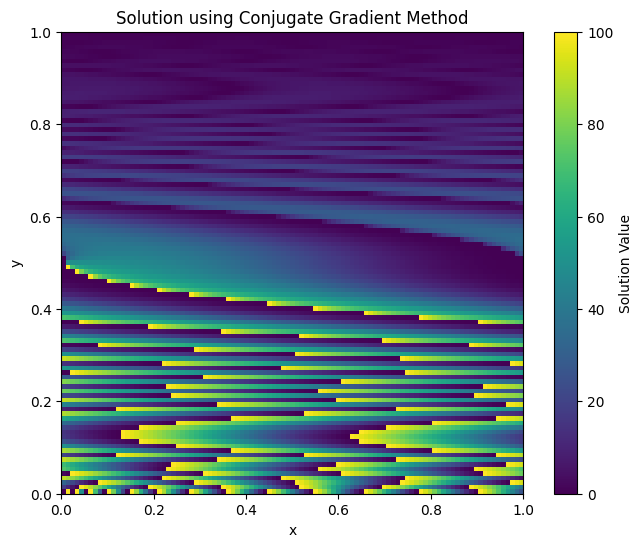

In [25]:
# Plot the solution using imshow
plt.figure(figsize=(8, 6))
plt.imshow(u_reshaped_grad_precond, extent=[0, 1, 0, 1], origin="lower", cmap="viridis")
plt.colorbar(label="Solution Value")
plt.title("Solution using Conjugate Gradient Method")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

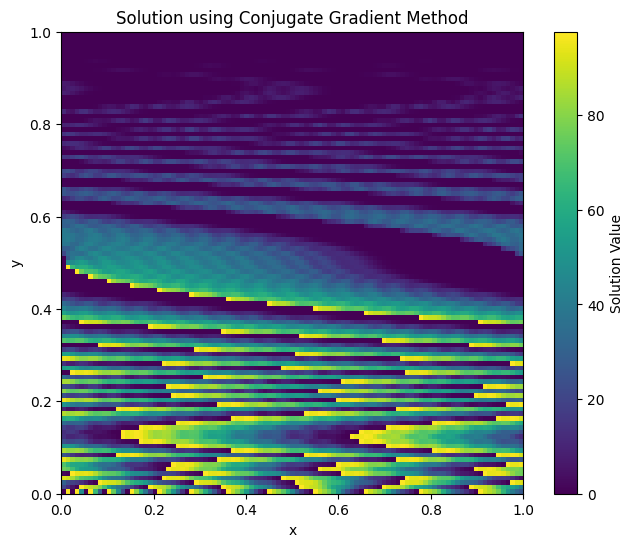

In [35]:
# Plot the solution using imshow
plt.figure(figsize=(8, 6))
plt.imshow(u_reshaped_cg, extent=[0, 1, 0, 1], origin="lower", cmap="viridis")
plt.colorbar(label="Solution Value")
plt.title("Solution using Conjugate Gradient Method")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

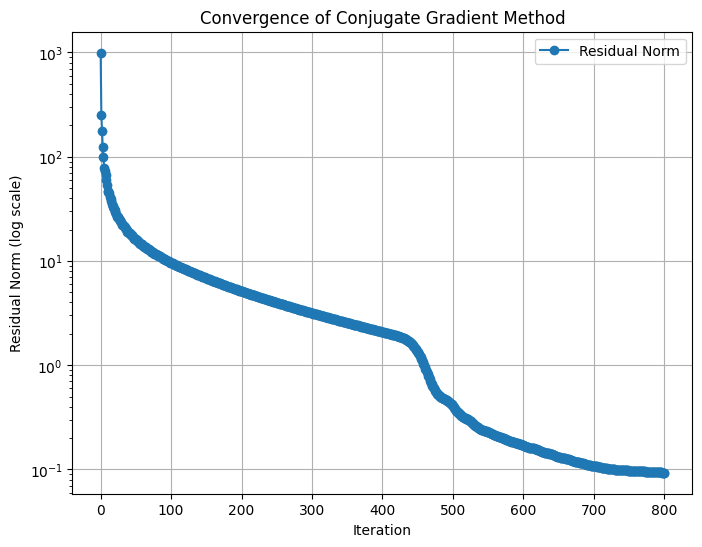

In [26]:
# Plot the convergence of residuals
plt.figure(figsize=(8, 6))
plt.semilogy(residuals, marker="o", label="Residual Norm")
plt.title("Convergence of Conjugate Gradient Method")
plt.xlabel("Iteration")
plt.ylabel("Residual Norm (log scale)")
plt.legend()
plt.grid(True)
plt.show()

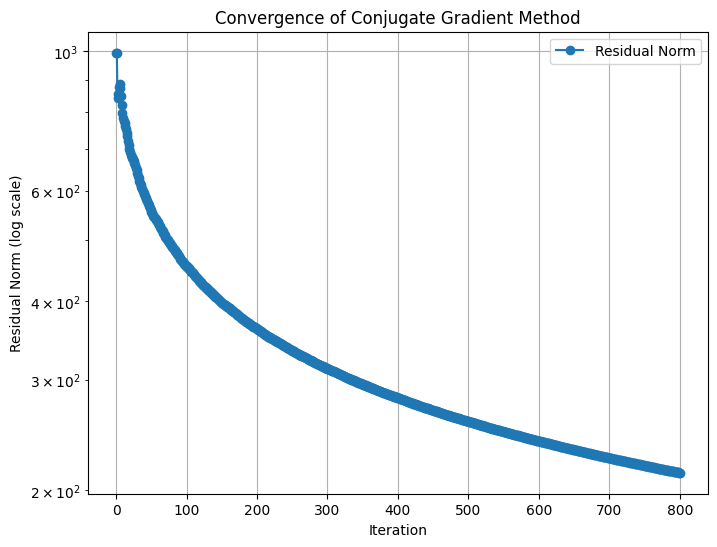

In [36]:
# Plot the convergence of residuals
plt.figure(figsize=(8, 6))
plt.semilogy(residuals_cg, marker="o", label="Residual Norm")
plt.title("Convergence of Conjugate Gradient Method")
plt.xlabel("Iteration")
plt.ylabel("Residual Norm (log scale)")
plt.legend()
plt.grid(True)
plt.show()

In [32]:
# Solve the system using the conjugate residual method
solution_cr, residuals = conjugate_residual_precond(Ak_np, x0, L_np, max_iter, tol)

# Create a mapping from coord_map to indices in xy
coord_map_indices = {tuple(coord): i for i, coord in enumerate(coord_map)}

# Use the mapping to assign values from solution_cg to the correct positions in u_reshaped
u_reshaped_res = np.zeros((n + 1, n + 1))

for j, coord in enumerate(xy):
    index = coord_map_indices.get(tuple(coord))
    if index is not None:
        u_reshaped_res[j // (n + 1), j % (n + 1)] = solution_cr[index]


# Map the solution to the mesh grid
# u_reshaped = np.zeros((n + 1) * (n + 1))

# for i, coord in tqdm(enumerate(coord_map)):
#     for j, xy_val in enumerate(xy):
#         if np.allclose(coord, xy_val):
#             u_reshaped[j] = solution_cg[i]

u_reshaped_res = u_reshaped_res.reshape(n + 1, n + 1)

# # Map the solution to the mesh grid
# u_reshaped_res = np.zeros((n + 1) * (n + 1))

# for i, coord in enumerate(coord_map):
#     for j, xy_val in enumerate(xy):
#         if np.allclose(coord, xy_val):
#             u_reshaped_res[j] = solution_cr[i]

# u_reshaped_res = u_reshaped_res.reshape(n + 1, n + 1)

100%|██████████| 800/800 [12:54<00:00,  1.03it/s]


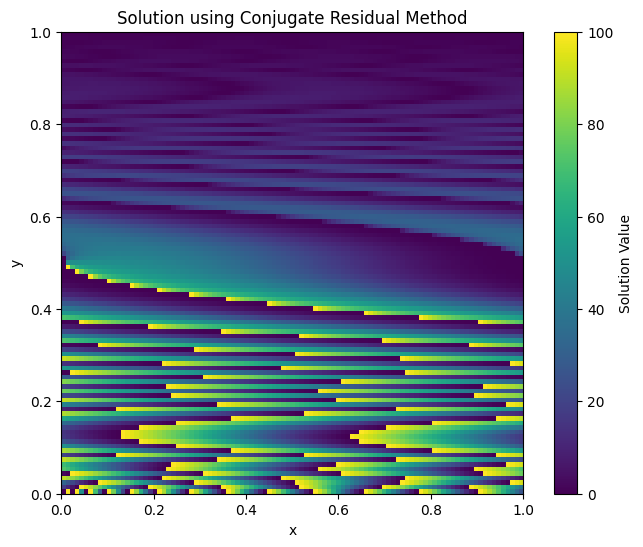

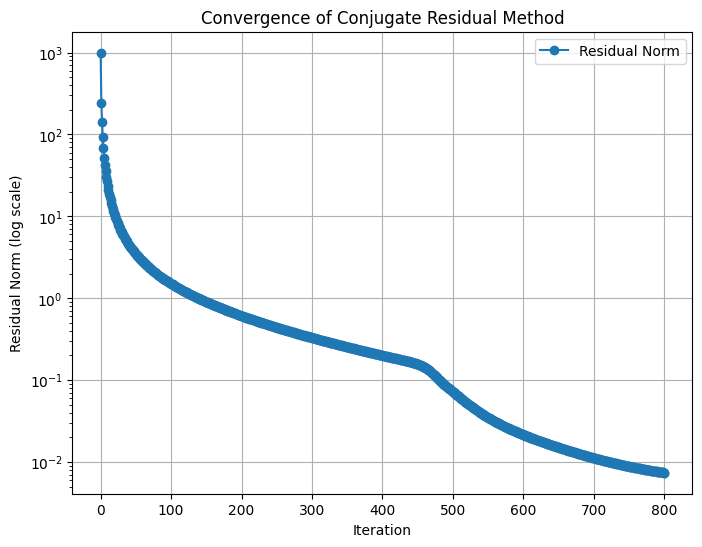

In [33]:
# Plot the solution using imshow
plt.figure(figsize=(8, 6))
plt.imshow(u_reshaped_res, extent=[0, 1, 0, 1], origin="lower", cmap="viridis")
plt.colorbar(label="Solution Value")
plt.title("Solution using Conjugate Residual Method")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

# Plot the convergence of residuals
plt.figure(figsize=(8, 6))
plt.semilogy(residuals, marker="o", label="Residual Norm")
plt.title("Convergence of Conjugate Residual Method")
plt.xlabel("Iteration")
plt.ylabel("Residual Norm (log scale)")
plt.legend()
plt.grid(True)
plt.show()

In [40]:
solution_cr,residuals_cr = conjugate_residual(Ak_np, L_np, x0, max_iter,tol) #A, x0, b, max_iter, tol

# Create a mapping from coord_map to indices in xy
coord_map_indices = {tuple(coord): i for i, coord in enumerate(coord_map)}

# Use the mapping to assign values from solution_cg to the correct positions in u_reshaped
u_reshaped_cr = np.zeros((n + 1, n + 1))

for j, coord in enumerate(xy):
    index = coord_map_indices.get(tuple(coord))
    if index is not None:
        u_reshaped_cr[j // (n + 1), j % (n + 1)] = solution_cr[index]


# Map the solution to the mesh grid
# u_reshaped = np.zeros((n + 1) * (n + 1))

# for i, coord in tqdm(enumerate(coord_map)):
#     for j, xy_val in enumerate(xy):
#         if np.allclose(coord, xy_val):
#             u_reshaped[j] = solution_cg[i]

u_reshaped_cr = u_reshaped_cr.reshape(n + 1, n + 1)


100%|██████████| 800/800 [01:20<00:00,  9.95it/s]


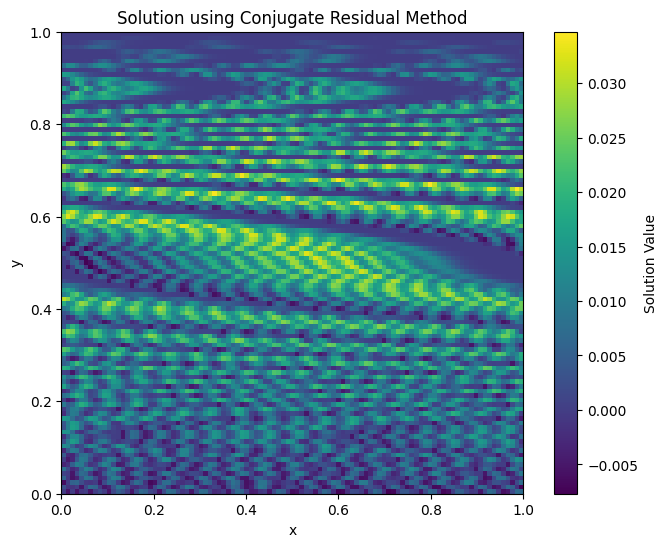

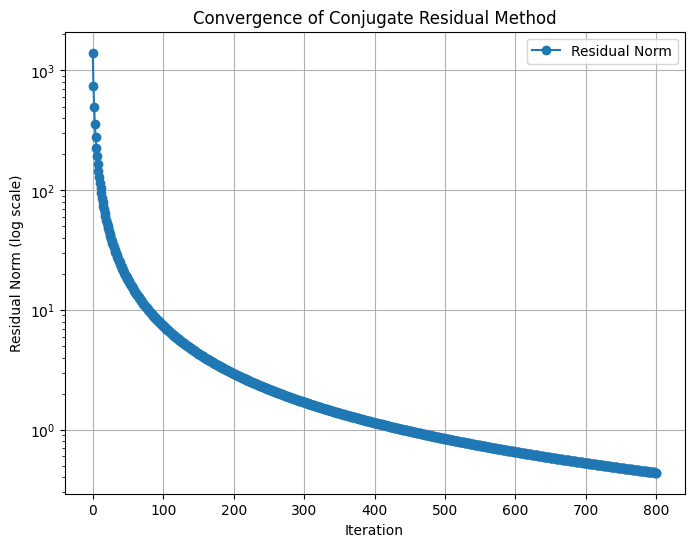

In [41]:
# Plot the solution using imshow
plt.figure(figsize=(8, 6))
plt.imshow(u_reshaped_cr, extent=[0, 1, 0, 1], origin="lower", cmap="viridis")
plt.colorbar(label="Solution Value")
plt.title("Solution using Conjugate Residual Method")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

# Plot the convergence of residuals
plt.figure(figsize=(8, 6))
plt.semilogy(residuals_cr, marker="o", label="Residual Norm")
plt.title("Convergence of Conjugate Residual Method")
plt.xlabel("Iteration")
plt.ylabel("Residual Norm (log scale)")
plt.legend()
plt.grid(True)
plt.show()